<img src='./img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='50%'></img>

<br>

<a href="./1_ltpy_v01_atmospheric_composition_overview.ipynb"><< 1 - Atmospheric composition data - Overview and data access </a>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space> <a href="./212_ltpy_v01_AC_SAF_L2_data.ipynb">212 - AC SAF Level 2 pre-processing >></a>

# 2.1.1 AC SAF - Near-real time (NRT) and Offline (Level 2) products

AC SAF Level 2 data products are available as `near-real time (NRT)` and `offline`. NRT data products are available within three hours from sensing for the past two months. Offline products are available within 15 days from sensing at latest, but typical is a delay of 2-3 days.  AC SAF Level 2 data are disseminated in `HDF5` data format.

There are two modules on AC SAF Level 2 products. This module (2.1.1) shows how AC SAF Level 2 data can be loaded and explains the general structure. [Module 2.1.2](./212_ltpy_v01_AC_SAF_L2_data.ipynb) shows some pre-processing steps, such as `masking` to apply to the data.

#### This module has the following outline:
* [1 - Load and browse AC SAF Level 2 products](#load)
* [2 - Build a xarray DataArray object for a AC SAF Level 2 parameter](#build_xarray)
* [3 - Combine multiple HDF5 files in a xarray DataArray object](#combine)

#### Load required libraries

In [1]:
import os
import h5py
from netCDF4 import Dataset, MFDataset
import xarray as xr
import numpy as np
import pandas
import datetime

# Python libraries for visualisation
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from IPython.display import display, clear_output

<hr>

## <a id="load"></a>Load and browse AC SAF Level 2 products

[h5py](http://docs.h5py.org/en/stable/) is a Python library that let's you access and manipulate data sets in HDF5 data format.

### Structure of AC SAF Level 2 product data files

The data in the HDF5 file is organized in five groups:
* META_DATA
 * Product Metadata
* GEOLOCATION
 * Date & Time (all retrievals)
 * 4 Corner Coordinates & Centre of Ground Pixel
 * Solar, Line-of-Sight Zenith, and realtive Azimuth angles at TOA
 * Orbit information
* TOTAL_COLUMNS
 * Total and tropospheric column amounts of the various trace gases with corresponding (relative) errors
* DETAILED_RESULTS
 * Geophysical parameters (surface, cloud and aerosol values)
 * Vertical column, slant column, and AMF values with corresponding errors
 * Fittings diagnostics (chi-square, RMS, etc.)
 * Various subgroups for trace gas specific data (e.g. O<sub>3</sub>, NO<sub>2</sub>, SO<sub>2</sub>, etc.)
* CLOUD_PROPERTIES
 * Retrieve cloud properties

### Load HDF5 data with h5py

A HDF5 file can be openend with the `File` function of the h5py package. The read attribute `r` gives read permission, but does not overwrite the original data file. The file object acts like a Python dictionary. Thus, the `keys` function allows us to see the different groups the file contains.

In [2]:
file = h5py.File('./eodata/gome2/offline/2a/2019/08/18/GOME_O3-NO2-NO2Tropo-BrO-SO2-H2O-HCHO_L2_20190818000913_050_METOPA_66564_DLR_04.HDF5', 'r')
groups = sorted(file.keys())
groups

['CLOUD_PROPERTIES',
 'DETAILED_RESULTS',
 'GEOLOCATION',
 'META_DATA',
 'TOTAL_COLUMNS']

Each group contains multiple variables. We can print out all variables of each group nicely formatted. This gives us a helpful overview of available parameters. We are mostly interested in parameters of the `GEOLOCATION` and `TOTAL_COLUMNS` groups.

We see that one AC SAF Level 2 data file contains trace gas total columns of six parameters:
* `BrO` - Hypobromite
* `H`<sub>`2`</sub>`O` - Water vapour
* `HCHO` - Formaldehyde
* `NO`<sub>`2`</sub> - Nitrogen Dioxide
* `O`<sub>`3`</sub> - Ozone
* `SO`<sub>`2`</sub> - Sulfur Dioxide

Additionally, the data file contains the tropospheric vertical column of Nitrogen Dioxide:
* `NO`<sub>`2`</sub> `Tropo` - Tropospheric Nitrogen Dioxide

In [3]:
 for group in groups:
    print('{}:'.format(group))
    # variables in a group
    variables = sorted(file[group].keys())
    # pretty print of variables in 3 columns
    for v1, v2, v3 in zip(variables[::3], variables[1::3], variables[2::3]):
        print('   - {:<30}- {:<30}- {:<}'.format(v1, v2, v3))
    if (len(variables) % 3) == 1:
        print('   - {:<30}'.format(variables[-1]))
    elif (len(variables) % 3) == 2:
        print('   - {:<30}- {:<}'.format(*variables[-2:]))
    # white line between one line and another
    print()

CLOUD_PROPERTIES:
   - CloudFraction                 - CloudFraction_Error           - CloudMode
   - CloudOpticalThickness         - CloudOpticalThickness_Error   - CloudTopAlbedo
   - CloudTopAlbedo_Error          - CloudTopHeight                - CloudTopHeight_Error
   - CloudTopPressure              - CloudTopPressure_Error        - CloudType
   - PMDCloudFraction              

DETAILED_RESULTS:
   - AAI                           - AMFToCloudTop                 - AMFToCloudTop_Error
   - AMFToGround                   - AMFToGround_Error             - AMFTotal
   - AMFTotal_Error                - BrO                           - Clouds
   - ESC                           - ESC_Error                     - FittingChiSquare
   - FittingGoodness               - FittingNumberOfIterations     - FittingRMS
   - H2O                           - HCHO                          - IntensityWeightedCloudFraction
   - NO2                           - O3                            - QualityFlags
   -

### Select and retrieve one specific parameter from a HDF5 file group

Let's say, we are interested in the Total vertical column density of Nitrogen-Dioxide (NO<sub>2</sub>). We can retrieve the parameter values by selecting the internal path of the data file: `TOTAL_COLUMNS/NO2`. The resulting object is a HDF5 dataset, which has a shape of a 1-dimensional vector.

In [5]:
no2 = file['TOTAL_COLUMNS/NO2Tropo']
no2

<HDF5 dataset "NO2Tropo": shape (15149,), type "<f4">

<br>

Attributes of the NO<sub>2</sub> object can be accessed with the `attrs` function. Atrributes are  helpful to better understand the parameter, e.g. we get information about minimum and maximum values of the parameter and the unit of the data values.

In [6]:
dict(no2.attrs)

{'CheckSum': array([-63449668], dtype=int32),
 'FillValue': array([-1.], dtype=float32),
 'Title': array([b'Tropospheric vertical column density of NO2'], dtype='|S43'),
 'Unit': array([b'mol/cm2'], dtype='|S7'),
 'ValueRangeMax': array([1.9275766e+16], dtype=float32),
 'ValueRangeMin': array([-3.2502144e+15], dtype=float32)}

<br>

Data values can be accessed with `[()]` function, which returns the data values as a numpy array.

In [7]:
no2[()]

array([-1., -1., -1., ..., -1., -1., -1.], dtype=float32)

<br>

## <a id="build_xarray"></a>Build a xarray `DataArray` object for a AC SAF Level 2 parameter

For easier handling and plotting of the parameters, we combine geolocation information and data values in a xarray `DataArray` structure, which can be created with the xarray `DataArray` constructor. 

The constructor takes:
* `data`: an array of values (can be e.g. a numpy ndarray, but also a `Series`, `DataFrame` or `Panel`)
* `dims`: a list of dimension names
* `coords`: a list or dictionary of coordinates
* `attrs`: a dictionary of attributes to add to the instance

We take the centre of the ground pixel as coordinates of the `DataArray`. The values can be retrieved from the internal paths `GEOLOCATION/LatitudeCentre` and `GEOLOCATION/LongitudeCentre` respectively.

The resulting object is a xarray `DataArray` instance with latitude and longitude information and the NO<sub>2</sub> values as data values. The `DataArray` object contains around 15 000 ground pixels.

In [10]:
latitude = file['GEOLOCATION/LatitudeCentre']
longitude = file['GEOLOCATION/LongitudeCentre']

no2_da = xr.DataArray(
    no2[()],
    dims=('ground_pixel'),
    coords={
        'latitude': ('ground_pixel', latitude[:]),
        'longitude': ('ground_pixel', longitude[:])
    },
    attrs={'long_name': 'Vertical column density of tropospheric NO2', 'units': 'mol/cm2'},
    name='tropospheric_column_NO2'
)

no2_da

<xarray.DataArray 'tropospheric_column_NO2' (ground_pixel: 15149)>
array([-1., -1., -1., ..., -1., -1., -1.], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 63.487015 63.81676 ... -62.004383
    longitude  (ground_pixel) float32 293.3269 293.0064 ... 105.10608 106.36275
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Vertical column density of tropospheric NO2
    units:      mol/cm2

<br>

### Plotting example of AC SAF Level 2 products - Single file with `PlateCarree` projection

We can continue to plot (visualize) the `DataArray` object. Python provides several plotting libraries. One extensive plotting library is [matplotlib](https://matplotlib.org/).

[Cartopy](https://scitools.org.uk/cartopy/docs/latest/) is another useful Python package. Key features of `cartopy` are its object-oriented [projection definitions](https://scitools.org.uk/cartopy/docs/latest/crs/projections.html), and its ability to transform points, lines, vectors, polygons and images between those projections. Cartopy includes a programmatic interface built on top of Matplotlib for the creation of publication quality maps.

As basemap, we create a map in a `PlateCarree` projection. We add coast- and gridlines. On top of the basemap, we plot the NO<sub>2</sub> values as a scatter plot, with the `scatter` function. As we might need to reuse the code for plotting, we define a plotting function called [visualize_gome_l2](./ltpy_functions.ipynb#visualize_gome_l2).

In [11]:
def visualize_gome_l2(xr_dataarray, conversion_factor, projection, vmin, vmax, color_scale,set_global=False):
    """ 
    Visualizes a xarray DataArray in a mollweide projection using matplotlib's scatter function.
    
    Parameters:
        xr_dataarray(xarrayDataArray): a one-dimensional xarray DataArray object with latitude and longitude information as coordinates
        conversion_factor(float): any number to convert the DataArray values
        color_scale(str): string taken from matplotlib's color ramp reference
        vmin(int): minimum number on visualisation legend
        vmax(int): maximum number on visualisation legend
    """
    fig, ax = plt.subplots(figsize=(40, 10))
    ax = plt.axes(projection=projection)

    ax.coastlines()
    if set_global:
        ax.set_global()

    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.xlabels_top=False
    gl.ylabels_right=False
    gl.xformatter=LONGITUDE_FORMATTER
    gl.yformatter=LATITUDE_FORMATTER
    
    gl.xlabel_style={'size':14}
    gl.ylabel_style={'size':14}

    # plot pixel positions
    img = ax.scatter(
        xr_dataarray.longitude.data,
        xr_dataarray.latitude.data,
        c=xr_dataarray.data*conversion_factor,
        cmap=plt.cm.get_cmap(color_scale),
        marker='o',
        s=0.5,
        transform=ccrs.PlateCarree(),
        vmin=vmin,
        vmax=vmax
    )

    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel("Longitude", fontsize=16)
    plt.ylabel("Latitude", fontsize=16)
    cbar = fig.colorbar(img, ax=ax, orientation='horizontal', fraction=0.04, pad=0.1)
    cbar.set_label(xr_dataarray.units, fontsize=16)
    cbar.ax.tick_params(labelsize=14)
    ax.set_title(xr_dataarray.long_name, fontsize=20, pad=20.0)
    plt.show()

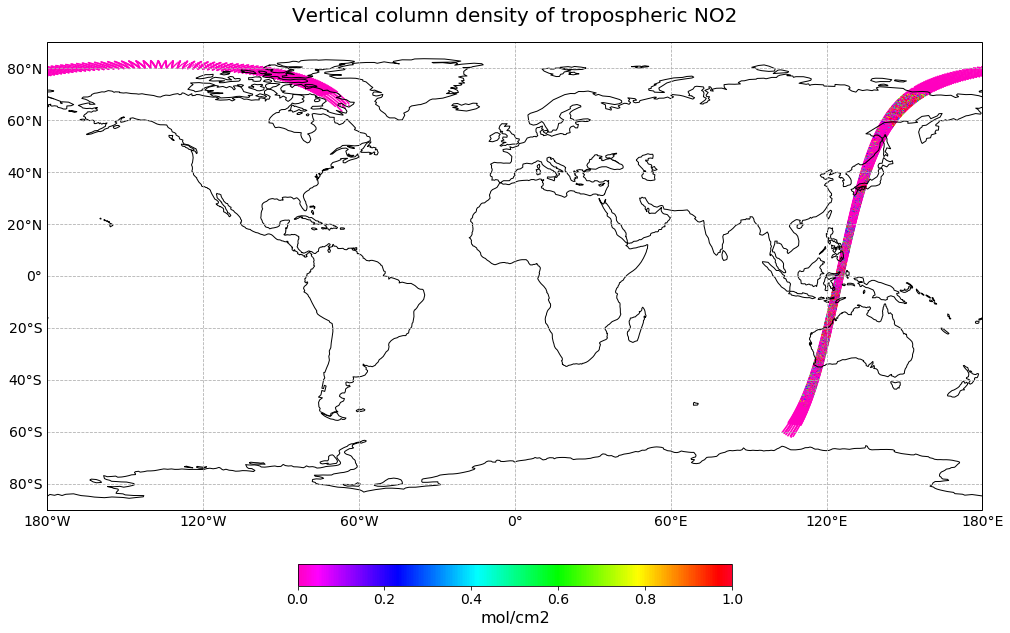

In [38]:
visualize_gome_l2(no2_da, 1e-15, ccrs.PlateCarree(),0,1,'gist_rainbow_r',set_global=True)

The example above shows that one individual file contains the data for one ground track. If we want to see all the data that has been sensed on one individual day, we have to combine multiple HDF5 files.

## <a id="combine"></a>Combine multiple HDF5 files in a xarray `DataArray` object

AC SAF Level 2 data files for one individual day are stored in multiple files. In order to combine all sensed ground tracks for one individual day, we can combine the steps above in a for loop:

* 1) Open the HDF5 file with `h5py.File` <br>
* 2) Retrieve information on `GEOLOCATION` and the `TOTAL_COLUMNS` parameter of interest
* 3) Generate a xarray `DataArray` and store it in a list of DataArrays
* 4) Concatenate the the DataArrays into one `DataArray` with `xarray.concat`

We combined the steps above in a function called [load_l2_data_xr](./ltpy_functions.ipynb#load_l2_data_xr).

The result is a 1-dimensional `DataArray` containing the ground pixels of all GOME-2A files for one specific day. We see that the `DataArray` object contains now multiple 100 000 ground pixels.

In [15]:
def load_l2_data_xr(directory, internal_filepath, parameter, longname, unit, name):
    """ 
    Loads a Metop-A/B Level 2 dataset in HDF format and returns a xarray DataArray with all the ground pixels of all GOME-2A files for one specific day
    
    Parameters:
        directory: directory where the HDF files are stored
        internal_filepath: internal path of the data file that is of interest, e.g. TOTAL_COLUMNS
        parameter: paramter that is of interest, e.g. NO2
        longname: Descriptive name of the variable stored in the resulting xarray DataArray
        unit: Unit of the parameter
        name: short name of the variable
    
    Returns:
        1-dimensional xarray DataArray with latitude / longitude information as coordinate information
    """
    fileList = os.listdir(directory)
    datasets = []

    for i in fileList:
        fullpath=os.path.join(directory, i)
        tmp = h5py.File(fullpath, 'r')
        groups =tmp.keys()
        tmp[internal_filepath]
        latitude = tmp['GEOLOCATION/LatitudeCentre']
        longitude = tmp['GEOLOCATION/LongitudeCentre']
        param = tmp[internal_filepath+'/'+parameter]
        da_tmp = xr.DataArray(
            param[()],
            dims=('ground_pixel'),
            coords={
                'latitude': ('ground_pixel', latitude[:]),
                'longitude': ('ground_pixel', longitude[:])
            },
            attrs={'long_name': longname, 'units': unit},
            name=name
        )
        datasets.append(da_tmp)

    return xr.concat(datasets, dim='ground_pixel')

In [16]:
directory_2a = './eodata/gome2/offline/2a//2019/08/18/'
no2_a_da_mf = load_l2_data_xr(directory_2a, 'TOTAL_COLUMNS', 'NO2Tropo', 'Tropospheric column density of NO2', 'mol/cm2', 'vertical_column_NO2')
no2_a_da_mf

<xarray.DataArray 'vertical_column_NO2' (ground_pixel: 223224)>
array([-1., -1., -1., ..., -1., -1., -1.], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 63.854996 64.1843 ... -63.2107 -63.55267
    longitude  (ground_pixel) float32 323.52814 323.20117 ... 343.05618
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Tropospheric column density of NO2
    units:      mol/cm2

<br>

### Plotting example of AC SAF Level 2 products - Multiple files with `Mollweide` projection

The plotting example above showed that the `PlateCarree` projection is not the best suited projection for representing the GOME-2 ground tracks. Thus, all ground tracks of one day, we want to visualize in `Mollweide` projection. We change our basemap to the `Mollweide` projection and add a transform argument to our scatter plot, in order to transform our coordinates to a `Mollweide` projection.

We define the function [visualize_gome_mollweide](./ltpy_functions.ipynb#visualize_gome_mollweide) to visualize the data in a `Mollweide` projection, which is more appropriate to visualize the ground tracks.

In [17]:
def visualize_gome_mollweide(xr_dataarray, conversion_factor, color_scale, vmin, vmax):
    """ 
    Visualizes a xarray dataarray in a mollweide projection using matplotlib's scatter function.
    
    Parameters:
        xr_dataarray(xarrayDataArray): a three-dimensional xarray DataArray object
        conversion_factor(float): any number to convert the DataArray values
        color_scale(str): string taken from matplotlib's color ramp reference  
        vmin(int): minimum number on visualisation legend
        vmax(int): maximum number on visualisation legend
    """
    fig, ax = plt.subplots(figsize=(40, 10))
    ax = plt.axes(projection=ccrs.Mollweide())

    ax.coastlines()
    ax.set_global()

    ax.gridlines(linestyle='--')
    # plot pixel positions
    img = ax.scatter(
        xr_dataarray.longitude.data,
        xr_dataarray.latitude.data,
        c=xr_dataarray.data*conversion_factor,
        cmap=plt.cm.get_cmap(color_scale),
        marker='o',
        s=0.5,
        transform=ccrs.PlateCarree(),
        vmin=vmin,
        vmax=vmax
    )

    cbar = fig.colorbar(img, ax=ax, orientation='horizontal', fraction=0.04, pad=0.1)
    cbar.set_label(xr_dataarray.units, fontsize=16)
    cbar.ax.tick_params(labelsize=14)
    ax.set_title(xr_dataarray.long_name, fontsize=20, pad=20.0)
    plt.show()

<br>

Let's visualize the ground tracks of all the measured values of MetOp-A for 18 August 2019. We see that the unfiltered data may contain negative values. Measurements can further be influenced by clouds. Thus, the next step is to mask the data and filter invalid ground pixels.

Go to [module 2.1.2](./212_ltpy_v01_AC_SAF_L2.ipynb) to see further pre-processing steps for AC SAF Level 2 data.

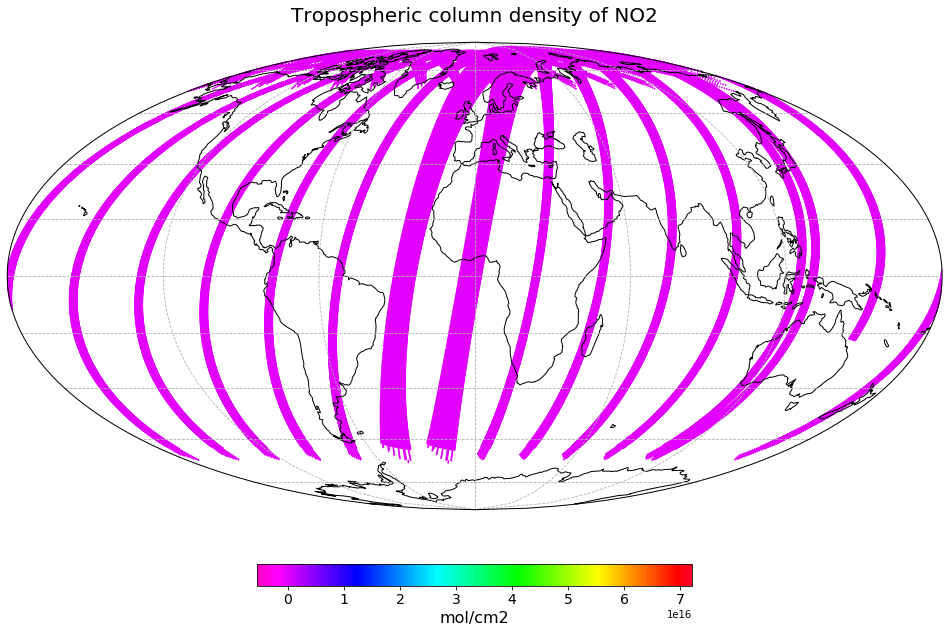

In [18]:
visualize_gome_mollweide(no2_a_da_mf, 1e-15, 'gist_rainbow_r', no2_a_da_mf.data.min(), no2_a_da_mf.data.max())

<br>

<hr>

<p style="text-align:left;">This project is licensed under the <a href="./LICENSE">MIT License</a> <span style="float:right;"><a href="https://gitlab.eumetsat.int/eo-lab/training-atmospheric-composition/">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:training@eumetsat.int>Contact</a></span></p>